<center><h1> Analyzing Multi-Party Turn-Taking Behavior </h1>


<h4> James Trujillo ( j.p.trujillo@uva.nl )<br>
    Updated: 04-23-2024 </h4>
    
<img src="./images/envision_banner.png" alt="isolated" width="300"/> 

<h3> Info documents </h3>
This module gives an introduction to analyzing the turn-taking behavior of a group of individuals. We'll use manual annotations of speech behavior, quantify the timing of turn transitions as gaps and overlaps between speakers, and look at some ways we can perform additional analyses, such as taking the entropy of turn-transitions.
<br><br>

<b>Packages:</b>
    
* pympi

* antropy

* SciPy
<br><br>
 
    
<b>Module citation: </b>
Trujillo, J.P. (2024-04-23). <i> Analyzing Multi-Party Turn-Taking Behavior </i> \[day you visited the site]. Retrieved from: https://envisionbox.org/turntaking_entropy.html 
<br>

<b>Location Repository:</b>

https://github.com/jptrujillo/turntaking_entropy_module
<br><br>

 
<b> Note on automatic utterance extraction:</b>
This module is partially based on the processing and analysis pipeline described in a previous publication (see below). The OSF project for this article also contains code for automatically extracting and processing single utterances from the audio stream. Note that this does require separate audio streams (e.g., from separate microphones) for each speaker. Code available at:  https://osf.io/bvm56/?view_only=7165d0c25f9344a592685f4bae0c1bf7

* Trujillo J.P., Levinson S.C., Holler J. (2021) Visual Information in Computer-Mediated Interaction Matters: Investigating the Association Between the Availability of Gesture and Turn Transition Timing in Conversation. In: Kurosu M. (eds) Human-Computer Interaction. Design and User Experience Case Studies. HCII 2021. Lecture Notes in Computer Science, vol 12764. Springer, Cham. https://doi.org/10.1007/978-3-030-78468-3_44
Open Access link: https://pure.mpg.de/rest/items/item_3347812/component/file_3347813/content
<br><br>


<h3>Introduction</h3>
Turn-taking is a fundamental aspect of human communication, and takes place quite rapidly, with turn transitions (i.e., the time between one speaker's utterance ending and the next speaker's utterance beginning) often on the scale of ~200ms (Stivers et al., doi:10.1073pnas.0903616106%20pna/). This timing is important not only for fast-pace information exchange, but is socially meaningful, as longer-than-expected inter-speaker gaps can be interpreted as signalling a dispreferred response (Kendrick & Torreira 2015  doi: 10.1080/0163853X.2014.955997). <br>
Beyond theoretical interest, quantifying turn-taking behavior can be interesting for understanding group dynamics. One study suggests that smoother turn transitions (i.e., shorter gaps, shorter overlaps) are more associated with collaborative behaviors compared to conflict behaviors (Kim et al., 2015, INTERSPEECH). Similarly, Pincus & Guastello (2005; DOI: 10.1177/1046496405280864) used non-linear dynamics approaches to show that information theoretic patterns in turn-taking behavior correlate with self-report measures of group dynamics (e.g., leadership, conflict). More recently, Hamish et al., (2023: https://escholarship.org/uc/item/2hb5k9fx ) have examined turn-taking entropy and critical instability (also described in this module) in relation to collaborative problem solving.


In [1]:
from parselmouth.praat import call
import os
import pympi
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal


In [2]:
 
def get_multispeaker_transitions(utterances_1, utterances_2, utterances_3):
    # set max distance between them to be 2s, then find the closest occurence in
    # second dataframe. Max distance is based on Heldner & Edlund 2010
    # output times are in ms
    
    speaker_count = 3
    if not utterances_1:
        speaker_count -=1
    if not utterances_2:
        speaker_count -=1
    if not utterances_3:
        speaker_count -=1
    
    if speaker_count < 2: 
        trans_dur = np.nan
        gap_dur = np.nan
        utterance_time_trans = np.nan
        utterance_time_gap = np.nan
    else:
        trans_dur1, gap_dur1, utterance_time_trans1, utterance_time_gap1, overlap_dur1, utterance_time_overlap1,timestamp1 = get_gaps_overlaps(
          utterances_1, utterances_2, utterances_3)
        trans_dur2, gap_dur2, utterance_time_trans2, utterance_time_gap2, overlap_dur2, utterance_time_overlap2,timestamp2 = get_gaps_overlaps(
          utterances_2, utterances_1, utterances_3) 
        trans_dur3, gap_dur3, utterance_time_trans3, utterance_time_gap3, overlap_dur3, utterance_time_overlap3,timestamp3 = get_gaps_overlaps(
          utterances_3, utterances_2, utterances_1) 
        
    
        print("Turn Transition Statistics for Participant 1")
        get_turn_trans_stats(trans_dur1,gap_dur1, overlap_dur1)
        print("Turn Transition Statistics for Participant 2")
        get_turn_trans_stats(trans_dur2,gap_dur2, overlap_dur2)
        print("Turn Transition Statistics for Participant 3")
        get_turn_trans_stats(trans_dur3,gap_dur3, overlap_dur3)
        
        # these will be used in the dataframe to indicate which speaker we're talking about
        p1 = ["1"]*len(trans_dur1)
        p2 = ["2"]*len(trans_dur2)
        p3 = ["3"]*len(trans_dur3)
        
        participant = p1 + p2 + p3
        timestamp = timestamp1 + timestamp2 + timestamp3

        # now we need to stack the utterance data
        trans_dur = trans_dur1 + trans_dur2 + trans_dur3
        utterance_time_trans = utterance_time_trans1 + utterance_time_trans2 + utterance_time_trans3
        
        df = pd.DataFrame(np.column_stack([participant,timestamp,trans_dur, utterance_time_trans]),
                               columns=['participant', 'timestamp','transition_duration','utterance_duration']
                               )
        
        return df
        
        
def get_gaps_overlaps(utterances_1, utterances_2, utterances_3):
    # this gets the utterance and turn-transition speaker from the perspective of one speaker
    # It doesn't matter what order the second two are in, as we just care about the averages in 
    # the end anyway
    trans_dur = []
    utterance_time_trans = []
    timestamp=[]

    for u_idx,u in enumerate(utterances_1):
        # here we want to get the difference between this utterance's offset (u[1]) and all onsets from the other two speakers
        diffs2 = [abs(u[1] - u2[0]) for u2 in utterances_2]
        diffs3 = [abs(u[1] - u3[0]) for u3 in utterances_3]

        min_dif2 = np.argmin(diffs2)
        min_dif3 = np.argmin(diffs3)        

        # also get within-speaker differences
        # we get this to make sure our inter-speaker differences are less than this
        # otherwise, we may not be getting the turn transition from this utterance
        if u_idx < len(utterances_1)-1:
            min_pause = utterances_1[u_idx+1][0] - u[1]
        else:
            # if this is not the last utterance, we ignore this
            min_pause = min([diffs2[min_dif2],diffs3[min_dif3]]) +1
        # is there an utterance from p2 or p3 starting within 2s of this utterance from p1?

        if diffs2[min_dif2] < 2000 and diffs2[min_dif2] < min_pause:
            trans_dur.append(int(utterances_2[min_dif2][0] - u[1]))
            utterance_time_trans.append(int(utterances_1[u_idx][1] - utterances_1[u_idx][0]))
            timestamp.append(int(utterances_2[min_dif2][0]))
        if diffs3[min_dif3] < 2000 and diffs3[min_dif3] < min_pause:
            trans_dur.append(int(utterances_3[min_dif3][0] - u[1]))
            utterance_time_trans.append(int(utterances_1[u_idx][1] - utterances_1[u_idx][0]))
            timestamp.append(int(utterances_3[min_dif3][0]))
            
    # finally, we want to separate these values into gaps and overlaps
    gap_dur = []
    overlap_dur = []
    utterance_time_gap = []
    utterance_time_overlap = []
    for idx, val in enumerate(trans_dur):
        if val > 0:
            gap_dur.append(val)
            utterance_time_gap.append(int(utterance_time_trans[idx]))
        elif val <= 0:
            overlap_dur.append(val)
            utterance_time_overlap.append(int(utterance_time_trans[idx]))

    return trans_dur, gap_dur, utterance_time_trans, utterance_time_gap, overlap_dur, utterance_time_overlap,timestamp
        

This function just gets us some summary stats for the turn taking behavior

In [3]:
def get_turn_trans_stats(transitions, gaps, overlaps):
    if transitions and not np.all(np.isnan(transitions)):
        Gap_freq = len(gaps)/len(transitions)
        Overlap_freq = len(overlaps)/len(transitions)
    else:
        Gap_freq = 0
        Overlap_freq = 0
    turn_data = [['turn transition mean', np.mean(transitions)],
                 ['turn transition SD', np.std(transitions)],
                 ['turn transition median',np.median(transitions)],
                 ['Gap mean', np.mean(gaps)],
                 ['Gap SD',np.std(gaps)],
                 ['Gap median',  np.median(gaps)],
                 ['Gap freq. (%)',Gap_freq],
                 ['Overlap mean', np.mean(overlaps)],
                 ['Overlap SD',np.std(overlaps)],
                 ['Overlap median',  np.median(overlaps)],
                 ['Overlap freq. (%)',Overlap_freq],]
    
    print(tabulate(turn_data, headers=['Stat','Value']))

## Descriptive Statistics
Let's see what we can learn just from these turn transition times. 
Several of these measures can inform us about speaker dominance. Who's taking and holding the floor the most? 

In [4]:
annot_dir = "./annotations/" 

annotation_files = os.listdir(annot_dir)
eafob = pympi.Elan.Eaf(annot_dir + annotation_files[0])


utterances_1 = [annotation for annotation in eafob.get_annotation_data_for_tier("Participant1")]
utterances_2 = [annotation for annotation in eafob.get_annotation_data_for_tier("Participant2")]
utterances_3 = [annotation for annotation in eafob.get_annotation_data_for_tier("Participant3")]

df = get_multispeaker_transitions(utterances_1, utterances_2, utterances_3)

Turn Transition Statistics for Participant 1
Stat                          Value
----------------------  -----------
turn transition mean       4.25794
turn transition SD       667.521
turn transition median    25
Gap mean                 439.965
Gap SD                   439.934
Gap median               304.5
Gap freq. (%)              0.563492
Overlap mean            -558.2
Overlap SD               457.736
Overlap median          -494
Overlap freq. (%)          0.436508
Turn Transition Statistics for Participant 2
Stat                          Value
----------------------  -----------
turn transition mean      42.6245
turn transition SD       688.131
turn transition median    49
Gap mean                 435.401
Gap SD                   467.993
Gap median               249
Gap freq. (%)              0.601533
Overlap mean            -550.317
Overlap SD               522.741
Overlap median          -389
Overlap freq. (%)          0.398467
Turn Transition Statistics for Participant 3
Stat

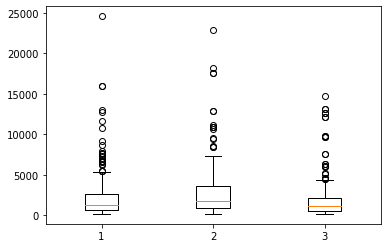

In [5]:
dur_1 = pd.to_numeric(df[df["participant"]=="1"]["utterance_duration"])
dur_2 = pd.to_numeric(df[df["participant"]=="2"]["utterance_duration"])
dur_3 = pd.to_numeric(df[df["participant"]=="3"]["utterance_duration"])

plt.boxplot([dur_1, dur_2, dur_3])
plt.show()

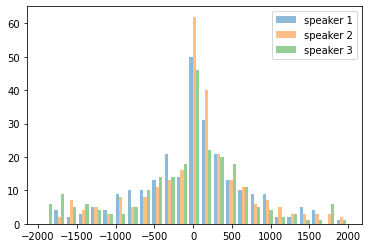

In [6]:
df.transition_duration = pd.to_numeric(df.transition_duration, errors='coerce')

# plotting
tt_1 = df[df["participant"]=="1"]["transition_duration"]
tt_2 = df[df["participant"]=="2"]["transition_duration"]
tt_3 = df[df["participant"]=="3"]["transition_duration"]
plt.hist([tt_1,tt_2,tt_3], 
         alpha=0.5, bins=25, 
         label=["speaker 1","speaker 2","speaker 3"])
plt.legend(loc='upper right')
plt.show()


The above output shows the turn transition information for each person in our interaction. Remember that each of the values are based on the transitions <i>from</i> this speaker's uterance. So for example, speaker 1 has a gap frequency of 56%, and an overlap frequency of 66%. This means that when speaker 1 finishes an utterance, s/he is "interrupted" 44% of the time (on average by 558ms), but typically there is a gap of 439ms before the next speaker begins their untterance. <br>
This information can already be useful for looking into how individual speakers behave with one another. One way to proceed with this data would be to simply take these summary values, per individual, per group, and statistically compare groups with one another. Do certain groups have smoother turn transition timings? We can also correlate the turn timings with other information, such as KAI scores. 

## Entropy of Turn Timing
Another way to capture the dynamics of turn-taking behavior is to look at Approximate Entropy. In order to have an idea of what this provides us, let's consider the statistics output above. In a perfectly 'stable' back-and-forth interaction, each turn transition could be approximately 36ms, across the entire interaction. We would then get a mean turn transition time of 4ms, with a SD of 667ms (as seen above for speaker 1 -- reflecting the tendency around 0). However, it may be that these values change over the course of the interaction, and knowing the mean won't necessarily let you accurately predict the next transition time. The latter case is an example of higher entropy. 

In [7]:
import antropy as ant

In [8]:
# first we need to sort this into a proper timeseries, disregarding individual IDs
df.timestamp = pd.to_numeric(df.timestamp, errors='coerce')
df.transition_duration = pd.to_numeric(df.transition_duration, errors='coerce')

sort_df = df.sort_values(by=["timestamp"], ascending=True)

sort_df.head()

,participant,timestamp,transition_duration,utterance_duration
513,3,5910,520,1090
252,2,9480,690,2880
0,1,10810,20,1310
253,2,11525,5,710
1,1,20350,925,7900


In [9]:
# Calculate Approximate entropy
print(ant.sample_entropy(sort_df["transition_duration"]))

1.95732579813899


Aside from the general entropy across the whole session, which we could compare across groups or correlate with personal or group characteristics, we can also look at the change in entropy over time. We'll split the session into 4 minute windows to assess entropy across the session.<br>

For the analysis, we'll use the categorical data corresponding to the "transitioning speaker" and calculate Permutation Entropy. Permutation entropy captures the ordering of values in a time-series. In this case, we want the complexity with which the group switches from one speaker to the next. Is it always speaker 1 followed by speaker 2, and vice versa? This would be low entropy. Or do we see all possible orders; speaker 3, then 1, followed by 3 again, then 2.. The more unpredictable the switching, the higher the entropy.<br>

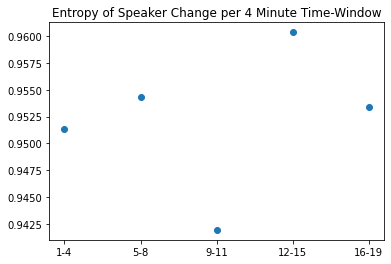

In [10]:
tt_entropy = []

window_length = (1000*60)*4 #written out just to make the window length easily understandable

window_start = 0
window_end = window_length 
while window_end < sort_df["timestamp"][len(sort_df)-1]   :
    # get data for this time window
    window = sort_df[(sort_df["timestamp"] >window_start)&(sort_df["timestamp"] <window_end)]
    # calculate permutation entropy
    tt_entropy.append(ant.perm_entropy(window["participant"], normalize=True))
    # shift the window forward
    window_start = window_end
    window_end += window_length
    
# now plot the entropy over time
plt.scatter(["1-4","5-8","9-11","12-15","16-19"],tt_entropy)
plt.title("Entropy of Speaker Change per 4 Minute Time-Window")
plt.show()


These values can again be correlated with group level characteristics, or to momentary annotations regarding breakthroughs, changes in topic, etc.<br>

## Linking turn-taking entropy to communicative success
Ideally, we will also have some additional information about what is happening during a conversation. For example, we may have annotations regarding certain interaction events (e.g., moments of disagreement, changes in topic), or some indication of communicative success, such as in collaborative problem solving tasks. By relating such annotations to turn-taking entropy, we can learn about how the dynamics of turn-taking relate to what is actually happening during the conversation. <br>
We'll use the open access Weights Task Dataset from Ibrahim and colleagues (2024) as an example. The data can be downloaded from: https://zenodo.org/records/10252341 <br>
For this module, we'll focuse on the _Oracle.csv files, which provide transcriptions of all of the interactions within each group. This will allow us to calculate turn-taking (entropy) as shown above.

In [11]:
CPS = pd.read_csv("All_Groups_CPS.csv")

# first get the unique group IDs
groups = set(CPS["Group"])
# We'll look at "constructing shared knowledge", but this is predictive of the team's score
CPS_cols = [colname for colname in CPS.columns if colname.startswith("CPS_CONST")]

constr_score = []

for group in groups:
    subset = CPS[CPS["Group"] == group]
    CPS_count = subset.count()
    # this will be the number of events labelled as "constructing shared knowledge"
    const = sum(CPS_count[CPS_cols])
    constr_score.append(const)
    
print(groups)
print(constr_score)

{'Group_02', 'Group_03', 'Group_06', 'Group_01', 'Group_05', 'Group_09', 'Group_08', 'Group_07', 'Group_04', 'Group_10'}
[72, 97, 90, 80, 107, 49, 133, 189, 80, 172]



Now we need to calculate the turn-taking entropy for these groups.

In [12]:
%%capture
import scipy.stats

group_entropy = []

# for each of our groups..
for group in groups:
    transcript = pd.read_csv(group + "_Oracle.csv")
    utterances_1 = transcript[transcript["Participant"] == 1]
    utterances_1_SE = [(utterance[1]["Start"]*1000,utterance[1]["End"]*1000) for utterance in utterances_1.iterrows()]
    utterances_2 = transcript[transcript["Participant"] == 2]
    utterances_2_SE = [(utterance[1]["Start"]*1000,utterance[1]["End"]*1000) for utterance in utterances_2.iterrows()]
    utterances_3 = transcript[transcript["Participant"] == 3]
    utterances_3_SE = [(utterance[1]["Start"]*1000,utterance[1]["End"]*1000) for utterance in utterances_3.iterrows()]
    
    # ..get the turn-transition dataframes..
    df_cps = get_multispeaker_transitions(utterances_1_SE, utterances_2_SE, utterances_3_SE)
    
    # .. and then calculate entropy
    # first we need to sort this into a proper timeseries, disregarding individual IDs
    df_cps.timestamp = pd.to_numeric(df_cps.timestamp, errors='coerce')
    df_cps.transition_duration = pd.to_numeric(df_cps.transition_duration, errors='coerce')

    sort_df = df_cps.sort_values(by=["timestamp"], ascending=True)

    # Calculate Approximate entropy
    entropy = ant.sample_entropy(sort_df["transition_duration"])
    group_entropy.append(entropy)

In [13]:
df_cps_full = pd.DataFrame(list(zip(groups, constr_score, group_entropy)),
                          columns = ["group","constr","entropy"])

In [14]:
df_cps_full

,group,constr,entropy
0,Group_02,72,2.120264
1,Group_03,97,1.821612
2,Group_06,90,1.838279
3,Group_01,80,2.019338
4,Group_05,107,1.734601
5,Group_09,49,2.014903
6,Group_08,133,1.989290
7,Group_07,189,2.065190
8,Group_04,80,1.820747
9,Group_10,172,1.945910


The average entropy over each group's interaction is easy to calculate, and we may want to correlate it with other high-level chacteristics. For example, the "constr" score that we calculated above is a measure of how frequently a group engaged in "constructing shared knowledge". Is frequent co-construction of shared knowledge associated with lower entropy? <br> 
We may also be interested in whether groups that are faster at completing the task have overall lower entropy.In this case, we can simply calculate their "time on task" based on the last timestamp in each group's transcript.
<br>
<b>Try for yourself:</b><br>
See if you can plot these associations, or even do some basic statistical analyses on these associations. Are they informative?

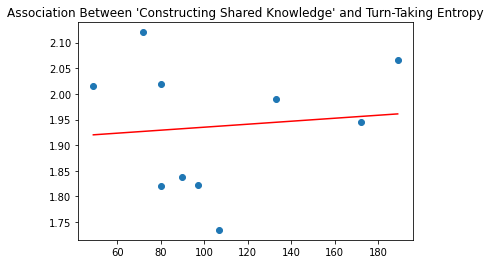

SpearmanrResult(correlation=-0.15197638592001614, pvalue=0.6751243317896831)

In [15]:
fit = np.polyfit(df_cps_full["constr"],df_cps_full["entropy"],1, full=True)
slope=fit[0][0]
intercept=fit[0][1]
xl = [min(df_cps_full["constr"]), max(df_cps_full["constr"])]
yl = [slope*xx + intercept  for xx in xl]


plt.scatter(df_cps_full["constr"],df_cps_full["entropy"])
plt.plot(xl, yl, '-r')
plt.title("Association Between 'Constructing Shared Knowledge' and Turn-Taking Entropy")
plt.show()

scipy.stats.spearmanr(df_cps_full["constr"],df_cps_full["entropy"])

In [16]:
time_on_task = []

for group in groups:
    transcript = pd.read_csv(group + "_Oracle.csv")
    ToT = transcript["End"].iloc[-1]
    time_on_task.append(ToT)
    
df_cps_full["ToT"] = time_on_task  


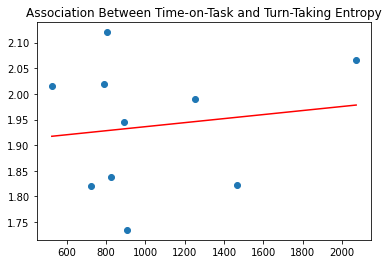

SpearmanrResult(correlation=-0.06666666666666665, pvalue=0.8548130882487426)

In [17]:
fit = np.polyfit(df_cps_full["ToT"],df_cps_full["entropy"],1, full=True)
slope=fit[0][0]
intercept=fit[0][1]
xl = [min(df_cps_full["ToT"]), max(df_cps_full["ToT"])]
yl = [slope*xx + intercept  for xx in xl]


plt.scatter(df_cps_full["ToT"],df_cps_full["entropy"])
plt.plot(xl, yl, '-r')
plt.title("Association Between Time-on-Task and Turn-Taking Entropy")
plt.show()

scipy.stats.spearmanr(df_cps_full["ToT"],df_cps_full["entropy"])

### Entropy Over Time 
While group-level entropy is easy to calculate, we can also use a sliding window approach to see how entropy develops over time. In the previous section of this module, we calculate entropy for several subsequent time windows. This may be useful, particularly if there are particular divisions in a conversational task. However, we may want to have a smoother approach, and use a sliding window, which provides finer temporal resolution. <br>
In this next code block, we'll calculate entropy over 60-second windows that will shift by 30-seconds, until we get to the end of the data.<br>
<b>Important to Note:</b><br>
While a smaller window provides finer temporal resolution, remember that turn-taking itself occurs on a particular timescale. So, your window should be large enough to capture several turn-exchanges. If the window is so small that it only ever captures 1 or 2 exchanges, the entropy values will be less informative than when you zoom out and take more data into the calculation.

In [18]:

#sliding window centering on each 1 minute segment
tt_entropy = []


window_length = (1000*60) #written out just to make the window length easily understandable
shift = (1000*30) # this is the amount that we will shift forward at each time step (here, it's 30 seconds)

window_start =sort_df["timestamp"].loc[0]
window_end =  window_start + window_length
while window_end < sort_df["timestamp"][len(sort_df)-1]   :
    # get data for this time window
    window = sort_df[(sort_df["timestamp"] >window_start)&(sort_df["timestamp"] <window_end)]
    if len(window) > 3:
    # calculate permutation entropy
        tt_entropy.append(ant.perm_entropy(window["transition_duration"], normalize=True))
    else:
        tt_entropy.append(np.nan)
    # shift the window forward by 30s
    window_start = window_end - shift
    window_end = window_start + window_length



Now, let's plot the data and see how entropy changes over the course of an interaction.<br>
<b>Try for yourself:</b><br>
Try changing the window_length and shift variables to see how this affects the visualized pattern. 

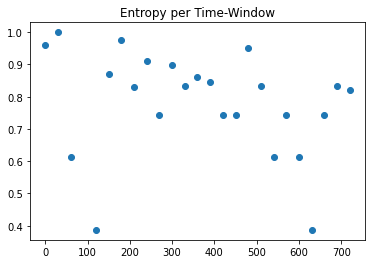

In [19]:
plt.scatter(list(range(0,len(tt_entropy)*30,30)),tt_entropy)
plt.title("Entropy per Time-Window")
plt.show()

One very useful application to having a time-course of entropy over the entire interaction, is that we can relate the entropy at specific points in the interaction to other (annotated) events. Does higher or lower entropy precede, or follow, particular events?<br>
We'll use a very quick and dirty example, by plotting moments when a team member solved a subtask within the larger CPS interaction. 

In [20]:
group_1 = CPS[CPS["Group"] == "Group_01"]
              
group_1_comp = [np.floor(row[1]["Start"]/30) for row in group_1.iterrows() if not np.isnan(row[1]["CPS_CONST_SharesU_CorrectSolutions"])]

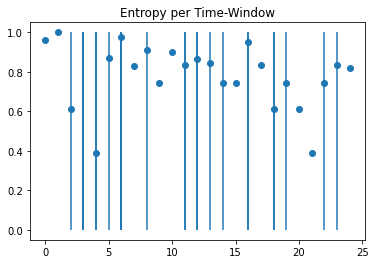

In [21]:

plt.scatter(range(len(tt_entropy)),tt_entropy)
plt.vlines(group_1_comp,0,1)
plt.title("Entropy per Time-Window")
plt.show()

### Calculating Dynamic Instability
While the entropy values themselves can be interesting, we may also be interested in the overal dynamic of the conversation or discussion. One way to do this is to calculate the number of moments of critical instability (Wiltshire, et al., 2021: https://doi.org/10.1109/ICHMS53169.2021.9582454), which we define as peaks in the turn-taking entropy. In other words, these are moments when the turn exchanges experience a sudden spike in instability, when the back-and-forth of conversation is highly unpredictable. These peaks are then followed by a return to a more stable (lower entropy) dynamic. 

We can use SciPy's find_peaks function to easily calculate this, although the height, prominence and distance values may need to be adjusted according to the way entropy is calculated. You can try to adjust these values and see how the following plot changes. Note that the orange points are considered the top of these peaks, and thus each represent a critical instability moment.

In [22]:
instability_peaks, instability_prominence = signal.find_peaks(tt_entropy, height=.4, prominence=0.2, distance=2)

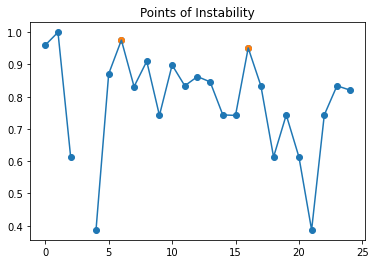

In [23]:
plt.scatter(range(len(tt_entropy)),tt_entropy)
plt.plot(range(len(tt_entropy)),tt_entropy)
plt.scatter(instability_peaks, instability_prominence["peak_heights"])
plt.title("Points of Instability")
plt.show()

Here, we'll return to our earlier loop, but now also calculate the number of critical instability moments for each group.

In [24]:
%%capture

group_instability_peaks = []

# for each of our groups..
for group in groups:
    transcript = pd.read_csv(group + "_Oracle.csv")
    utterances_1 = transcript[transcript["Participant"] == 1]
    utterances_1_SE = [(utterance[1]["Start"]*1000,utterance[1]["End"]*1000) for utterance in utterances_1.iterrows()]
    utterances_2 = transcript[transcript["Participant"] == 2]
    utterances_2_SE = [(utterance[1]["Start"]*1000,utterance[1]["End"]*1000) for utterance in utterances_2.iterrows()]
    utterances_3 = transcript[transcript["Participant"] == 3]
    utterances_3_SE = [(utterance[1]["Start"]*1000,utterance[1]["End"]*1000) for utterance in utterances_3.iterrows()]
    
    # ..get the turn-transition dataframes..
    df_cps = get_multispeaker_transitions(utterances_1_SE, utterances_2_SE, utterances_3_SE)
    
    # .. and then calculate entropy
    # first we need to sort this into a proper timeseries, disregarding individual IDs
    df_cps.timestamp = pd.to_numeric(df_cps.timestamp, errors='coerce')
    df_cps.transition_duration = pd.to_numeric(df_cps.transition_duration, errors='coerce')

    sort_df = df_cps.sort_values(by=["timestamp"], ascending=True)
    
    tt_entropy = []

    window_length = (1000*60) #written out just to make the window length easily understandable

    window_start =sort_df["timestamp"].loc[0]
    window_end =  window_start + window_length
    while window_end < sort_df["timestamp"][len(sort_df)-1]   :
        # get data for this time window
        window = sort_df[(sort_df["timestamp"] >window_start)&(sort_df["timestamp"] <window_end)]
        if len(window) > 3:
        # calculate permutation entropy
            tt_entropy.append(ant.perm_entropy(window["transition_duration"], normalize=True))
        else:
            tt_entropy.append(np.nan)
        # shift the window forward by 30s
        window_start = window_end - window_length/2 
        window_end = window_start + window_length

    instability_peaks, instability_prominence = signal.find_peaks(tt_entropy, height=.4, prominence=0.2, distance=2)
    
    group_instability_peaks.append(len(instability_peaks))

In team-based problem-solving tasks, moments of critical instability may be necessary changes in the dynamic of a conversation/discussion, where a team is (for example) changing strategies or trying to find a stable dynamic. Accordingly, many such changes in dynamics are likely to be associated with a longer time working on a problem. Teams that find a stable, effective dynamic with fewer such changes, will then be faster. Even without looking into what exactly is occurring during a conversation, this type of analysis can provide a first look at whether moments of critical instability are associated with how long it takes to complete a task.<br>
<b>Try for yourself:</b><br>
Just as above, see if you can plot the group_instability_peaks data against the time-on-task ("ToT") that we calculated earlier. Again, including a fit line and some basic statistics can provide an additional check on whether this critical instability is indeed a useful way to capture (the route to) collaborative communicative success.

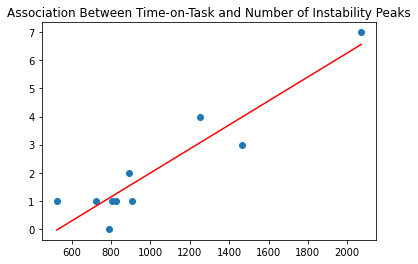

In [25]:
fit = np.polyfit(df_cps_full["ToT"], group_instability_peaks,1, full=True)
slope=fit[0][0]
intercept=fit[0][1]
xl = [min(df_cps_full["ToT"]), max(df_cps_full["ToT"])]
yl = [slope*xx + intercept  for xx in xl]


plt.scatter(df_cps_full["ToT"],group_instability_peaks)
plt.plot(xl, yl, '-r')
plt.title("Association Between Time-on-Task and Number of Instability Peaks")
plt.show()